In [1]:
from datetime import datetime as dt

import dash
import dash_bootstrap_components as dbc
import git
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import MATCH, Dash, Input, Output, callback, dcc, html
import networkx as nx


In [2]:
from vehicle_stream_pipeline import utils

In [190]:
repo = git.Repo(".", search_parent_directories=True).git.rev_parse("--show-toplevel")
# fetch data (here we can automate it)
df_stops = pd.read_excel(
    f"{repo}/data/other/MoDstops+Preismodell.xlsx", sheet_name="MoDstops"
)

df_edges = pd.read_excel(
    f"{repo}/data/other/MoDstops+Preismodell.xlsx", sheet_name="Liste 2022"
)
df_simulated = pd.read_csv(
    f"{repo}/data/sim_rides_2m.csv"
)

results = pd.read_csv(
    f"{repo}/data/graph_metrics_5Ksteps.csv"
)


In [7]:
repo = git.Repo(".", search_parent_directories=True).git.rev_parse("--show-toplevel")
results = pd.read_csv(
    f"{repo}/data/regression/graph_metrics_5Ksteps.csv"
)

In [5]:

df_edges.rename(columns={"Start #": "start_id", "Ende #": "end_id"}, inplace=True)

rides_df = pd.read_csv(f"{repo}/data/cleaning/data_cleaned.csv")
rides_df = rides_df[(rides_df["state"] == "completed")]
rides_df["scheduled_to"] = pd.to_datetime(rides_df["scheduled_to"])



In [ ]:
def getDeliveryTimes(rides_simulated, drone_radius=500):
    rides_simulated['scheduled_to'] = pd.to_datetime(rides_simulated['scheduled_to'])
    start_date = rides_simulated['scheduled_to'].min()
    end_date = rides_simulated['scheduled_to'].max()

    drives_without_drones = utils.calculate_drives(
        rides_simulated, start_date, end_date
    )
    graph_without_drones = utils.calculate_graph(drives_without_drones)
    if nx.is_strongly_connected(graph_without_drones):
        diameter = nx.diameter(graph_without_drones, weight="avg_time_to_destination")
    else: 
        diameter = 0
    avg = nx.average_shortest_path_length(graph_without_drones, weight="avg_time_to_destination")

    drone_spots = [15011, 13001, 2002, 11007, 4016, 1002, 3020, 9019, 9005]
    drives_with_drones = utils.add_drone_flights(
        df_edges, drives_without_drones, drone_spots=drone_spots, radius=drone_radius
    )
    graph_with_drones = utils.calculate_graph(drives_with_drones)
    if nx.is_strongly_connected(graph_with_drones):
        diameter_with_drones = nx.diameter(graph_with_drones, weight="avg_time_to_destination")
    else: 
        diameter = 0
    avg_with_drones = nx.average_shortest_path_length(graph_with_drones, weight="avg_time_to_destination")

    return [len(rides_simulated), diameter, avg, diameter_with_drones, avg_with_drones]

In [ ]:

results = pd.DataFrame(columns=["#_simulated_rides", "diameter_w/o_drones", "avg_w/o_drones", "diameter_with_drones", "avg_with_drones"])
for n in list(range(10000,2000000,5000)):
    current_sample_df = df_simulated.sample(n=n)
    results.loc[len(results)] = getDeliveryTimes(current_sample_df)



In [6]:
results.columns


Index(['Unnamed: 0', '#_simulated_rides', 'diameter_w/o_drones',
       'avg_w/o_drones', 'diameter_with_drones', 'avg_with_drones'],
      dtype='object')

In [ ]:
results.to_csv(f"{repo}/data/graph_metrics.csv")

In [7]:
import matplotlib.pyplot as plt

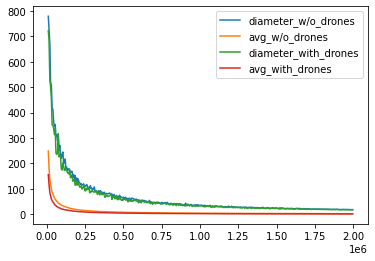

In [207]:
plt.plot(results["#_simulated_rides"],results['diameter_w/o_drones'], label='diameter_w/o_drones')
plt.plot(results["#_simulated_rides"],results['avg_w/o_drones'], label='avg_w/o_drones')
plt.plot(results["#_simulated_rides"],results['diameter_with_drones'], label='diameter_with_drones' )
plt.plot(results["#_simulated_rides"],results['avg_with_drones'], label='avg_with_drones' )

plt.legend()
plt.show()

In [37]:
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


In [191]:
# separate features and target variable
diameter = results['diameter_w/o_drones']

# special case: we only have one feature, so we must reshape the data here
features = results['#_simulated_rides'].values.reshape(-1, 1)

# create a train/test split
dia_train, dia_test, dia_target_train, dia_target_test = train_test_split(
    features, diameter, test_size=0.2, random_state=42)

In [194]:
# create a transformer that generates polynomial features
transformer = PolynomialFeatures(degree=2, include_bias=True)
estimator = LinearRegression()

pipeline = Pipeline([ ('transformer', transformer), ('estimator', estimator)])

pipeline.fit(dia_train, dia_target_train)

prediction = pipeline.predict(features)

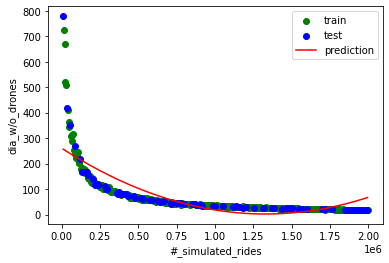

length = 0.0*1 + -0.00038884209015728244*age + 1.4621680884292776e-10*age^2 + 260.68176383099143


c:\Users\jostm7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [195]:
# plot the original values
plt.scatter(dia_train, dia_target_train, c='green', label='train')
plt.scatter(dia_test, dia_target_test, c='blue', label='test')

# create a new dataframe that contains the age and the predictions
d = results[['#_simulated_rides']]
d = d.assign(prediction=prediction)

# sort the data before plotting it
d = d.sort_values(by='#_simulated_rides')

# plot the predicted values
plt.plot(d['#_simulated_rides'], d['prediction'], c='red', label='prediction')

plt.xlabel('#_simulated_rides')
plt.ylabel('dia_w/o_drones')
plt.legend()
plt.show()


# print the model that was fitted (the regression formula)
print("length = ", end='')
for i, f in enumerate(pipeline.named_steps['transformer'].get_feature_names(['age'])):
    if i > 0:
        print(" + ", end='')
    print("{}*{}".format(pipeline.named_steps['estimator'].coef_[i], f), end='')
print(" + {}".format(pipeline.named_steps['estimator'].intercept_))

In [52]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# predict the values for the test data
predictions = pipeline.predict(dia_test)

# evaluate using different measures
mse = mean_squared_error(dia_target_test, predictions)
r2 = r2_score(dia_target_test, predictions)

print("MSE:", mse)
print("RMSE:", sqrt(mse))
print("R^2:", r2)

# print the model that was fitted (the regression formula)
print("length = ", end='')
for i, f in enumerate(pipeline.named_steps['transformer'].get_feature_names(['age'])):
    if i > 0:
        print(" + ", end='')
    print("{}*{}".format(pipeline.named_steps['estimator'].coef_[i], f), end='')
print(" + {}".format(pipeline.named_steps['estimator'].intercept_))

MSE: 1909.7007595578282
RMSE: 43.70012310689557
R^2: 0.39610568580040484
length = 0.0*1 + -0.00043070332168940997*age + 1.6058981775661854e-10*age^2 + 286.71686975338184


c:\Users\jostm7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Polynomial Regression with Numpy

c:\Users\jostm7\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
c:\Users\jostm7\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\jostm7\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


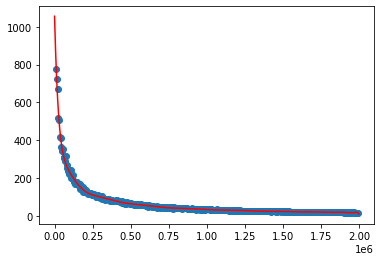

In [197]:
import numpy
import matplotlib.pyplot as plot

x = results['#_simulated_rides']
y = results['diameter_w/o_drones']

model = numpy.poly1d(numpy.polyfit(x, y, 30))

linesp = numpy.linspace(0, 2000000, 100000)

plot.scatter(x, y)
plot.plot(linesp, model(linesp),c='red')
plot.show()

In [209]:
print(model(1))
print(model(10000))
print(model(2000000))
print(model(5000000))
print(model(10000000))

1055.2240798356877
800.6494687144476
10.959487470506247
-6.967937485143859e+18
-8.430608701388883e+26


### Exponential Regression with Numpy

[-1.83731250e-06  5.61702567e+00]


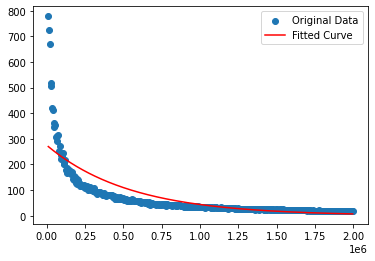

In [199]:
# x = np.divide(results['#_simulated_rides'].to_numpy(),10000)
x = results['#_simulated_rides'].to_numpy()
y = results['diameter_w/o_drones'].to_numpy()

def func(x, a, b):
    return np.exp(b) * np.exp(a * x) 

# popt = numpy.polyfit(x, numpy.log(y), 1) # biased towards small values
popt = numpy.polyfit(x, numpy.log(y), 1, w=numpy.sqrt(y))
print(popt)

plt.figure()
plt.scatter(x, y, label="Original Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()


In [200]:
print(func(0, *popt))
print(func(50000000, *popt))

275.07001667805395
3.4890667619684244e-38


### Exponential Regression with Scipy

[ 4.41320623e+06 -2.53034486e-01 -4.41317243e+06]


C:\Users\jostm7\AppData\Local\Temp/ipykernel_6648/522651494.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b / x) + c
c:\Users\jostm7\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


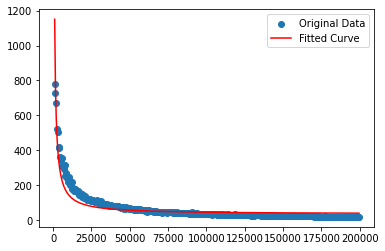

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b / x) + c

xdata = np.divide(results['#_simulated_rides'].to_numpy(),10) #needed to be normalized, else optimization not possible
ydata = results['diameter_w/o_drones'].to_numpy()

popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.figure()
plt.scatter(xdata, ydata, label="Original Data")
plt.plot(xdata, func(xdata, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [202]:
print(func(0, *popt))
print(func(50000000, *popt))


685.2485313200991
36.58469580007826
